# Importing the packages and data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import scipy
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from scipy.special import gamma, digamma, polygamma

from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import random

import scipy.optimize

In [3]:
import sys
sys.path.append("../smote_cd/")
from smote_cd.dataset_generation import softmax

In [4]:
import dirichlet_regression

# Creation of the simulated data

In [5]:
n = 1000 #nb of points
K = 2 #nb of features
J = 2 #nb of classes

In [6]:
X = np.random.normal(size=(n,K))

In [7]:
beta = np.random.randint(low=-5, high=5, size=(K,J))
beta[:,0] = 0
beta = np.array(beta,dtype=float)

In [8]:
beta

array([[0., 2.],
       [0., 2.]])

In [9]:
mu = dirichlet_regression.compute_mu(X, beta)

In [10]:
#Z = np.ones(np.shape(X))
#Z[:,1] += 1
Z = np.copy(X)
gamma_var = np.zeros(K)
phi = np.exp(np.matmul(Z,gamma_var))

#phi = np.ones(X.shape[0])

In [11]:
alpha = np.copy(mu)
for i in range(mu.shape[-1]):
    alpha[:,i] = phi*mu[:,i]

In [12]:
Y = np.zeros((n,J))
for i in range(n):
    Y[i] = np.random.dirichlet(alpha[i])

In [13]:
Y_star = (Y*(n-1)+1/J)/n

In [14]:
def dirichlet_ll(mu,Y,epsilon=0):
    n = np.shape(Y)[0]
    sum_ll = 0
    for i in range(n):
        term_B = np.sum(np.log(gamma(mu[i])))
        term_C = np.sum((mu[i]-1)*np.log(Y[i]+epsilon))
        sum_ll += - term_B + term_C
    return sum_ll

In [15]:
dirichlet_ll(mu,Y,epsilon=1e-200)

32688.64987919114

# Defining the functions

In [5]:
def f(x, X, Y, Z, epsilon=0):
    K = X.shape[-1]
    J = Y.shape[-1]
    print(x)
    beta = x[:K*J].reshape((K,J))
    beta[:,0] = 0
    gamma_var = x[K*J:]
    mu = dirichlet_regression.compute_mu(X, beta)
    phi = np.exp(np.matmul(Z,gamma_var))
    #alpha = np.copy(mu)
    #for i in range(mu.shape[-1]):
    #    alpha[:,i] = phi*mu[:,i]
    return -dirichlet_regression.dirichlet_loglikelihood(mu,phi,Y,epsilon=epsilon)

In [6]:
def fprime(x, X, Y, Z, epsilon=0):
    K = X.shape[-1]
    J = Y.shape[-1]
    beta = x[:K*J].reshape((K,J))
    beta[:,0] = 0
    gamma_var = x[K*J:]
    mu = dirichlet_regression.compute_mu(X, beta)
    phi = np.exp(np.matmul(Z,gamma_var))
    beta_grad = dirichlet_regression.dirichlet_gradient(mu, X, Y, epsilon=epsilon)
    gamma_grad = dirichlet_regression.dirichlet_derivative_wrt_gamma(mu, phi, beta, X, Y, Z, epsilon=epsilon)
    return(np.concatenate([beta_grad.flatten(),gamma_grad]))

In [101]:
dirichlet_regression.dirichlet_gradient(mu, X, Y_star)

array([[-233.63092477,  233.63092477],
       [ 390.6714507 , -390.6714507 ]])

In [104]:
%%time
fprime(np.concatenate([beta.flatten(),gamma_var]), X, Y, Z, epsilon=1e-200)

Wall time: 41.6 ms


array([-53.81276711,  53.81276711,  21.27329868, -21.27329868,
         8.02841731,  14.01289448])

In [106]:
beta0 = np.array([ [0., -2.], [0., 1.] ])
gamma_var0 = np.array([0.,0.])

In [111]:
%%time
solution=scipy.optimize.root(fprime, np.concatenate([beta0.flatten(),gamma_var0]), args=(X, Y, Z, 1e-200))

Wall time: 2.77 s


In [108]:
beta

array([[ 0., -1.],
       [ 0.,  2.]])

In [112]:
print(solution.message)
solution.x

The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.


array([ 0.        , -0.93640908,  0.        ,  1.97882121,  0.01069875,
        0.01474153])

In [24]:
fprime(solution.x,X,Y_star,Z)

array([-4.57411886e-14,  6.04516437e-14,  8.77076189e-15, -5.05151476e-15,
       -5.32907052e-15,  1.60427227e-14])

In [115]:
nb_points = [500,1000,2000,5000,10000,20000,40000]
solutions=[]
for nbp in nb_points:
    X = np.random.normal(size=(nbp,K))
    mu = dirichlet_regression.compute_mu(X, beta)
    Z = np.copy(X)
    gamma_var = np.zeros(K)
    phi = np.exp(np.matmul(Z,gamma_var))
    alpha = np.copy(mu)
    for i in range(mu.shape[-1]):
        alpha[:,i] = phi*mu[:,i]

    Y = np.zeros((nbp,J))
    for i in range(nbp):
        Y[i] = np.random.dirichlet(alpha[i])
    Y_star = (Y*(nbp-1)+1/J)/nbp
    
    solution=scipy.optimize.root(fprime, np.concatenate([beta0.flatten(),gamma_var0]), args=(X, Y, Z, 1e-200))
    print(solution.message)
    solutions.append(solution.x)

The solution converged.
The solution converged.
The solution converged.
The solution converged.
The solution converged.
The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
The solution converged.


In [116]:
solutions

[array([ 0.        , -0.95489985,  0.        ,  1.94885036, -0.01372306,
        -0.00858869]),
 array([ 0.        , -1.00023541,  0.        ,  1.94507178,  0.00588778,
         0.01300829]),
 array([ 0.        , -0.96035482,  0.        ,  2.00121691, -0.03643766,
        -0.00388542]),
 array([ 0.        , -0.9969869 ,  0.        ,  1.983427  ,  0.00329947,
         0.02214222]),
 array([ 0.        , -0.99600988,  0.        ,  1.99165289, -0.0091117 ,
        -0.00462273]),
 array([ 0.        , -0.99816477,  0.        ,  1.98125495, -0.00709168,
         0.01485576]),
 array([ 0.00000000e+00, -9.86738633e-01,  0.00000000e+00,  1.96155992e+00,
        -1.93457483e-03, -3.48742414e-03])]

In [31]:
nbp=1000

X = np.random.normal(size=(nbp,K))
mu = dirichlet_regression.compute_mu(X, beta)
Z = np.copy(X)
gamma_var = np.zeros(K)
phi = np.exp(np.matmul(Z,gamma_var))
alpha = np.copy(mu)
for i in range(mu.shape[-1]):
    alpha[:,i] = phi*mu[:,i]
    
Y = np.zeros((nbp,J))
for i in range(nbp):
    Y[i] = np.random.dirichlet(alpha[i])
Y_star = (Y+0.1e-200)/(1+0.1e-200)
    
solution=scipy.optimize.root(fprime, np.concatenate([beta0.flatten(),gamma_var0]), args=(X, Y_star, Z))

In [32]:
solution.x

array([ 0.        , -3.64553731,  0.        ,  0.89811362,  0.01685097,
       -0.0149323 ])

In [65]:
r2_score(Y, Y_star)

1.0

In [53]:
print("Likelihood with real parameters:", -f(np.concatenate([beta.flatten(),gamma_var]), X, Y_star, Z))
print("Likelihood with estimated parameters:",-f(solution.x,X,Y_star,Z))

Likelihood with real parameters: 666.1164550354915
Likelihood with estimated parameters: 3174.031396261097


In [54]:
mu_sol = dirichlet_regression.compute_mu(X, solution.x[:K*J].reshape(np.shape(beta)))

gamma_var_sol = solution.x[K*J:]
phi_sol = np.exp(np.matmul(Z,gamma_var_sol))

alpha_sol = np.copy(mu_sol)
for i in range(mu_sol.shape[-1]):
    alpha_sol[:,i] = phi_sol*mu_sol[:,i]

In [56]:
solution.x[:K*J].reshape(np.shape(beta))

array([[0.        , 0.8556936 ],
       [0.        , 1.31877078]])

In [58]:
dirichlet_regression.dirichlet_loglikelihood(mu, phi, Y_star)

4079.9039100954174

In [59]:
dirichlet_regression.dirichlet_loglikelihood(mu_sol, phi, Y_star)

5596.784826159632

In [78]:
beta1 = np.linspace(-20, 0, 40)
beta2 = np.linspace(0, 20, 40)
beta1v, beta2v = np.meshgrid(beta1, beta2)

In [79]:
%%time
list_loglikelihood = []
for b1, b2 in zip(beta1v.flatten(), beta2v.flatten()):
    beta_temp = np.array([[0.,b1],[0.,b2]])
    mu_temp = dirichlet_regression.compute_mu(X,beta_temp)
    list_loglikelihood.append(dirichlet_regression.dirichlet_loglikelihood(mu_temp, phi, Y_star))

Wall time: 33.2 s


<IPython.core.display.Javascript object>


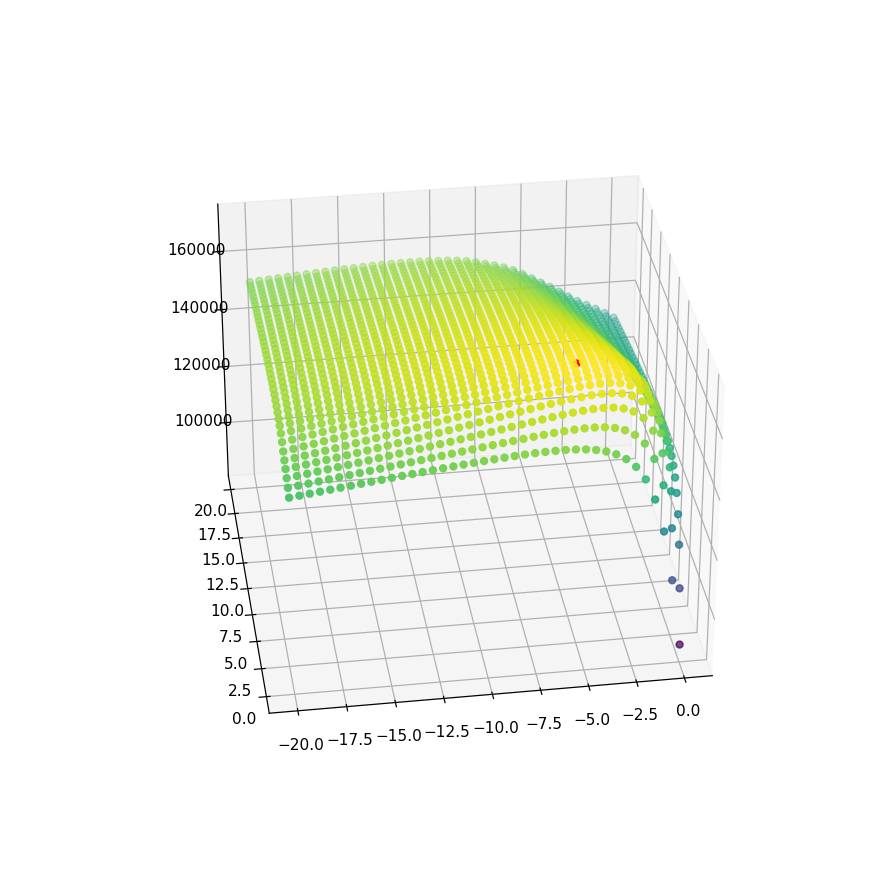

In [80]:
%matplotlib notebook
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection ='3d')
ax.scatter3D(beta1v.flatten(), beta2v.flatten(), np.array(list_loglikelihood), c=list_loglikelihood)
ax.scatter3D(-5,4,dirichlet_regression.dirichlet_loglikelihood(mu, phi, Y_star), c='red')
plt.show()

In [83]:
%%time
list_ll = []
for b1, b2 in zip(beta1v.flatten(), beta2v.flatten()):
    beta_temp = np.array([[0.,b1],[0.,b2]])
    mu_temp = dirichlet_regression.compute_mu(X,beta_temp)
    list_ll.append(dirichlet_ll(mu_temp, Y, epsilon=1e-200))

Wall time: 32.2 s


In [ ]:
%matplotlib inline

In [196]:
r2_score(Y_star,mu)

0.8353095849897278

In [202]:
r2_score(Y_star,mu_sol)

0.713461686937251

### With hessian

In [7]:
def fhessian(x, X, Y, Z):
    K = X.shape[-1]
    J = Y.shape[-1]
    beta = x[:K*J].reshape((K,J))
    beta[:,0] = 0
    gamma_var = x[K*J:]
    mu = dirichlet_regression.compute_mu(X, beta)
    phi = np.exp(np.matmul(Z,gamma_var))
    hessian = np.zeros((K*J+K,K*J+K))
    beta_hess = dirichlet_regression.dirichlet_hessian_wrt_beta(mu, phi, X, Y).reshape((K*J,K*J))
    gamma_hess = dirichlet_regression.dirichlet_hessian_wrt_gamma(mu, phi, beta, X, Y, Z)
    beta_gamma_derivative = dirichlet_regression.dirichlet_second_derivative_beta_gamma(mu, phi, beta, X, Y, Z).reshape((K,K*J)) 
    hessian[:K*J,:K*J] = beta_hess
    hessian[-K:,-K:] = gamma_hess
    hessian[:K*J,-K:] = beta_gamma_derivative.transpose()
    hessian[-K:,:K*J] = beta_gamma_derivative
    return(hessian)

In [33]:
%%time
hess_test = fhessian(np.concatenate([beta.flatten(),gamma_var]), X, Y_star, Z)

Wall time: 302 ms


In [34]:
%%time
solution=scipy.optimize.root(fprime, np.concatenate([beta0.flatten(),gamma_var0]), jac=fhessian, args=(X, Y_star, Z))

Wall time: 7.6 s


In [35]:
print(solution.message)
solution.x

The solution converged.


array([ 0.        , -3.64553731,  0.        ,  0.89811362,  0.01685097,
       -0.0149323 ])

# With Maupiti data ?

In [182]:
X_maupiti = pd.read_csv('../../Maupiti/maupiti_X_13244.csv', index_col=0)
Y_maupiti = pd.read_csv('../../Maupiti/maupiti_Y_13244.csv',index_col=0)

In [183]:
n_features = X_maupiti.shape[1]
n_classes = Y_maupiti.shape[1]
n_samples = X_maupiti.shape[0]

In [184]:
X_maupiti = np.array(X_maupiti)
Y_maupiti = np.array(Y_maupiti)

In [185]:
X_maupiti = X_maupiti/10000

In [193]:
np.shape(X_maupiti)

(13244, 16)

In [248]:
#X_maupiti_2 = np.ones((n_samples,1+n_features*2))
#X_maupiti_2[:,1:1+n_features] = X_maupiti
#X_maupiti_2[:,1+n_features:] = X_maupiti**2

X_maupiti_1 = np.ones((n_samples,1+n_features))
X_maupiti_1[:,1:] = X_maupiti

In [197]:
Y_star_maupiti = (Y_maupiti*(n_samples-1)+1/n_classes)/n_samples

In [249]:
#Z_maupiti = np.ones(np.shape(X_maupiti))
Z_maupiti = np.copy(X_maupiti)
Z_maupiti_1 = np.copy(X_maupiti_1)
Z_maupiti_2 = np.copy(X_maupiti_2)

In [250]:
beta_maupiti = np.ones((1+n_features)*n_classes+(1+n_features))[:(1+n_features)*n_classes].reshape(((1+n_features),n_classes))
beta_maupiti[:,0] = 0

In [264]:
X_maupiti_train = X_maupiti_1[2000:10000,:]
Y_star_maupiti_train = Y_star_maupiti[2000:10000,:]
Z_maupiti_train = Z_maupiti_1[2000:10000,:]

In [265]:
np.shape(X_maupiti_train)

(8000, 17)

In [266]:
%%time
solution_maupiti=scipy.optimize.root(fprime, np.zeros((1+n_features)*n_classes+(1+n_features)), 
                                     args=(X_maupiti_train, Y_star_maupiti_train, Z_maupiti_train))

C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:64: RuntimeWarning: invalid value encountered in multiply
  sum_mu_digamma_mu = np.sum(mu[i] * digamma_mu)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:80: RuntimeWarning: invalid value encountered in multiply
  derivative_gamma += Z[i,:]*phi[i]*( digamma(phi[i])+np.sum( mu[i]*(np.log(Y[i]+epsilon)-digamma(phi[i]*mu[i])) ) )


Wall time: 13min 22s


In [267]:
print(solution_maupiti.message)
solution_maupiti.x

The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.


array([ 0.00000000e+00,  4.99299173e-04, -9.92816950e-03, -4.90916518e-03,
       -3.14375881e-03,  1.35856612e-04,  1.61801106e-02, -5.85262338e-03,
       -3.98790709e-03,  9.84511811e-03,  0.00000000e+00, -1.52674183e-01,
       -3.51204391e-03, -2.79715141e-02, -2.53530410e-02, -1.06069316e-02,
        4.38541883e-02, -1.81879339e-02, -2.20893628e-02,  5.93632023e-03,
        0.00000000e+00, -1.16346092e-03,  8.85194672e-04, -2.47973126e-04,
       -2.73424886e-04, -1.23027363e-04, -2.25141896e-04, -1.77564207e-04,
       -2.47764618e-04, -5.61045503e-04,  0.00000000e+00, -3.18958825e+03,
        3.54575871e+02,  7.69334716e+01,  8.84176126e+01,  1.29788878e+02,
        4.12553852e+02,  3.86396801e+01,  9.04032704e+01, -2.32198146e+02,
        0.00000000e+00,  1.26449216e+02, -3.13434834e+01,  2.68660343e+01,
        4.04829567e+01,  3.48466679e+01,  1.40990452e+02, -1.33240171e+00,
        2.51639866e+01,  1.20861325e+02,  0.00000000e+00,  2.05190524e-01,
        1.28031854e-02,  

In [268]:
beta_maupiti = solution_maupiti.x[:(1+n_features)*n_classes].reshape(((1+n_features),n_classes))

In [269]:
beta_maupiti

array([[ 0.00000000e+00,  4.99299173e-04, -9.92816950e-03,
        -4.90916518e-03, -3.14375881e-03,  1.35856612e-04,
         1.61801106e-02, -5.85262338e-03, -3.98790709e-03,
         9.84511811e-03],
       [ 0.00000000e+00, -1.52674183e-01, -3.51204391e-03,
        -2.79715141e-02, -2.53530410e-02, -1.06069316e-02,
         4.38541883e-02, -1.81879339e-02, -2.20893628e-02,
         5.93632023e-03],
       [ 0.00000000e+00, -1.16346092e-03,  8.85194672e-04,
        -2.47973126e-04, -2.73424886e-04, -1.23027363e-04,
        -2.25141896e-04, -1.77564207e-04, -2.47764618e-04,
        -5.61045503e-04],
       [ 0.00000000e+00, -3.18958825e+03,  3.54575871e+02,
         7.69334716e+01,  8.84176126e+01,  1.29788878e+02,
         4.12553852e+02,  3.86396801e+01,  9.04032704e+01,
        -2.32198146e+02],
       [ 0.00000000e+00,  1.26449216e+02, -3.13434834e+01,
         2.68660343e+01,  4.04829567e+01,  3.48466679e+01,
         1.40990452e+02, -1.33240171e+00,  2.51639866e+01,
         1.

In [270]:
mu_maupiti = dirichlet_regression.compute_mu(X_maupiti_train, beta_maupiti)

gamma_var_maupiti = solution_maupiti.x[(1+n_features)*n_classes:]
phi_maupiti = np.exp(np.matmul(Z_maupiti_train,gamma_var_maupiti))

alpha_maupiti = np.copy(mu_maupiti)
for i in range(mu_maupiti.shape[-1]):
    alpha_maupiti[:,i] = phi_maupiti*mu_maupiti[:,i]

In [271]:
dirichlet_regression.dirichlet_loglikelihood(mu_maupiti,phi_maupiti,Y_star_maupiti_train)

568016.0466597767

In [272]:
mu_maupiti

array([[0.09644161, 0.12903978, 0.09011342, ..., 0.09555541, 0.09553641,
        0.10940674],
       [0.10071373, 0.09361845, 0.10009911, ..., 0.09940176, 0.0997901 ,
        0.09929323],
       [0.10168829, 0.09285406, 0.10425783, ..., 0.09797322, 0.09864558,
        0.0981441 ],
       ...,
       [0.10127855, 0.09226994, 0.10093602, ..., 0.09921769, 0.09964512,
        0.0983244 ],
       [0.10051239, 0.08505605, 0.09909841, ..., 0.10024391, 0.10075606,
        0.10270675],
       [0.09406436, 0.14661619, 0.08691615, ..., 0.0921553 , 0.09285731,
        0.10862155]])

In [273]:
r2_score(Y_star_maupiti_train, mu_maupiti)

-0.255171521040826

# With Arctic Lake

In [8]:
arctic = pd.read_csv('ArcticLake.csv')

In [9]:
Y_arctic = arctic.iloc[:,:3]
X_arctic = arctic.iloc[:,3]

In [10]:
Y_arctic = np.array(Y_arctic)

In [11]:
X_arctic = np.array([[j] for j in X_arctic])

In [12]:
Z_arctic = np.copy(X_arctic)

In [13]:
n_features = 1
n_classes = 3

In [14]:
beta0 = np.array([[0.02, 0.05, 0.06]])
gamma0 = [0]

In [15]:
%%time
solution_arctic=scipy.optimize.root(fprime, np.zeros(n_features*n_classes+n_features), 
                                     args=(X_arctic, Y_arctic, Z_arctic))

Wall time: 55.8 ms


In [16]:
print(solution_arctic.message)
solution_arctic.x

The solution converged.


array([0.        , 0.00736881, 0.00548126, 0.02476173])

In [17]:
beta_arctic = solution_arctic.x[:n_features*n_classes].reshape((n_features,n_classes))

In [18]:
mu_arctic = dirichlet_regression.compute_mu(X_arctic, beta_arctic)

gamma_var_arctic = solution_arctic.x[n_features*n_classes:]
phi_arctic = np.exp(np.matmul(Z_arctic,gamma_var_arctic))

alpha_arctic = np.copy(mu_arctic)
for i in range(mu_arctic.shape[-1]):
    alpha_arctic[:,i] = phi_arctic*mu_arctic[:,i]

In [19]:
r2_score(Y_arctic, mu_arctic)

-0.06867489816677978

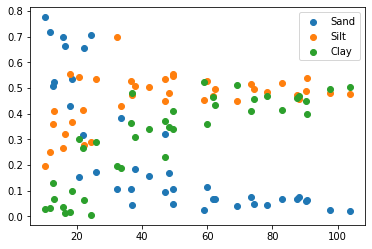

In [20]:
plt.scatter(X_arctic,Y_arctic[:,0],label='Sand')
plt.scatter(X_arctic,Y_arctic[:,1],label='Silt')
plt.scatter(X_arctic,Y_arctic[:,2],label='Clay')
plt.legend()
plt.show()

In [40]:
X_new = np.arange(10.4,103.7,0.5)
X_new = np.array([[j] for j in X_new])

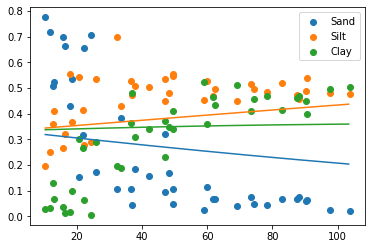

In [22]:
plt.scatter(X_arctic,Y_arctic[:,0],label='Sand')
plt.scatter(X_arctic,Y_arctic[:,1],label='Silt')
plt.scatter(X_arctic,Y_arctic[:,2],label='Clay')
plt.plot(X_new, dirichlet_regression.compute_mu(X_new, beta_arctic))
plt.legend()
plt.show()

## With scipy.optimize

In [28]:
from scipy.optimize import fmin, newton, minimize

In [29]:
def compute_mu_2(X, beta):
    n = np.shape(X)[0]
    J = np.shape(beta)[1]
    Xbeta = np.matmul(X,beta)
    mu = np.zeros((n,J))
    # compute the softmax
    for i in range(n):
        for j in range(J):
            mu[i,j] = 1/np.sum(np.exp(Xbeta[i]-Xbeta[i,j]))
        #mu[i,:] = exp_Xbeta[i,:]/sum_exp_Xbeta[i]
    return mu

### With an intercept

In [114]:
X_arctic_1 = np.ones((39,2))
X_arctic_1[:,1] = X_arctic[:,0]

In [115]:
Z_arctic_1 = np.ones(39)

In [174]:
beta0 = np.array([[0.1, -0.3, -1.1],[ 0.02, 0.05, 0.06]])
gamma0 = [0]
params0 = np.concatenate([beta0.flatten(),gamma0])

In [171]:
def f_arctic(x, X, Y, Z, epsilon=0):
    K = X.shape[-1]
    J = Y.shape[-1]
    beta = x[:K*J].reshape((K,J))
    beta[:,0] = 0
    gamma_var = x[K*J:]
    mu = dirichlet_regression.compute_mu(X, beta)
    #mu = compute_mu_2(X, beta)
    phi = np.exp(np.matmul(Z,gamma_var))
    #phi = np.ones(39)
    #alpha = np.copy(mu)
    #for i in range(mu.shape[-1]):
    #    alpha[:,i] = phi*mu[:,i]
    return -dirichlet_regression.dirichlet_loglikelihood(mu,phi,Y,epsilon=epsilon)

In [172]:
def fprime_arctic(x, X, Y, Z, epsilon=0):
    K = X.shape[-1]
    J = Y.shape[-1]
    beta = x[:K*J].reshape((K,J))
    beta[:,0] = 0
    gamma_var = x[K*J:]
    mu = dirichlet_regression.compute_mu(X, beta)
    #mu = compute_mu_2(X, beta)
    phi = np.exp(np.matmul(Z,gamma_var))
    #phi=np.ones(39)
    beta_grad = dirichlet_regression.dirichlet_gradient(mu, X, Y, epsilon=epsilon)
    gamma_grad = dirichlet_regression.dirichlet_derivative_wrt_gamma(mu, phi, beta, X, Y, Z, epsilon=epsilon)
    return(np.concatenate([beta_grad.flatten(),gamma_grad]))

In [118]:
params0

array([ 0.1 , -0.3 , -1.1 ,  0.02,  0.05,  0.06,  0.  ])

In [175]:
%%time
solution_arctic_bis=fmin(f_arctic, params0, args=(X_arctic_1, Y_arctic, np.ones(39).reshape((39,1))), maxiter=2000)

Optimization terminated successfully.
         Current function value: -77.728099
         Iterations: 605
         Function evaluations: 917
Wall time: 662 ms


In [177]:
solution_arctic_bis

array([ 0.        , -0.84168686, -2.27551817,  0.        ,  0.0392686 ,
        0.05623217,  2.62656005])

In [178]:
beta_arctic_1 = solution_arctic_bis[:(n_features+1)*n_classes].reshape((n_features+1,n_classes))

In [179]:
X_new_1 = np.arange(10.4,103.7,0.5)
X_new_1 = np.array([[1., j] for j in X_new_1])

In [180]:
mu_arctic_1 = dirichlet_regression.compute_mu(X_new_1, beta_arctic_1)

gamma_var_arctic_1 = solution_arctic_bis[(n_features+1)*n_classes:]
#phi_arctic_1 = np.exp(np.matmul(X_new_1,gamma_var_arctic_1))

#alpha_arctic_1 = np.copy(mu_arctic_1)
#for i in range(mu_arctic_1.shape[-1]):
#    alpha_arctic_1[:,i] = phi_arctic_1*mu_arctic_1[:,i]

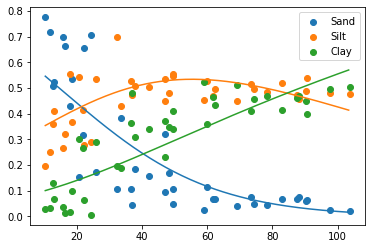

In [181]:
plt.scatter(X_arctic,Y_arctic[:,0],label='Sand')
plt.scatter(X_arctic,Y_arctic[:,1],label='Silt')
plt.scatter(X_arctic,Y_arctic[:,2],label='Clay')
plt.plot(X_new, mu_arctic_1)
plt.legend()
plt.show()

## With X^2

In [147]:
X_arctic_2 = np.ones((39,3))
X_arctic_2[:,1] = X_arctic[:,0]
X_arctic_2[:,2] = X_arctic[:,0]**2

In [148]:
Z_arctic_2 = X_arctic_2 / np.max(X_arctic_2)

In [ ]:
true_params = np.array([[0, -1.7471939375, -4.1558203475],
                       [0, 0.0949597540, 0.1551641068],
                       [0,  -0.0005857499, -0.0009607057]])
true_gamma = 2.9464265445
Z = np.ones(39)
true_phi = np.exp(Z*true_gamma)

In [191]:
beta0 = np.array([[ 0., -1.5, -4.], [0, 0.05, 0.1], [0., 0., 0.]])
gamma0 = [2.]
params0 = np.concatenate([beta0.flatten(),gamma0])

In [192]:
%%time
solution_arctic_bis=fmin(f_arctic, params0, args=(X_arctic_2, Y_arctic, np.ones(39).reshape(39,1)), maxiter=2000)

Optimization terminated successfully.
         Current function value: -91.280393
         Iterations: 827
         Function evaluations: 1207
Wall time: 828 ms


In [193]:
beta_arctic_2 = solution_arctic_bis[:(n_features+2)*n_classes].reshape((n_features+2,n_classes))

In [194]:
beta_arctic_2

array([[ 0.00000000e+00, -1.74712826e+00, -4.15553100e+00],
       [ 0.00000000e+00,  9.49556281e-02,  1.55153815e-01],
       [ 0.00000000e+00, -5.85733299e-04, -9.60647322e-04]])

In [195]:
X_new_2 = np.arange(10.4,103.7,0.5)
X_new_2 = np.array([[1., j, j**2] for j in X_new_2])

In [196]:
mu_arctic_2 = dirichlet_regression.compute_mu(X_new_2, beta_arctic_2)

gamma_var_arctic_2 = solution_arctic_bis[(n_features+2)*n_classes:]
phi_arctic_2 = np.exp(np.matmul(np.ones(39).reshape(39,1),gamma_var_arctic_2))

#alpha_arctic_2 = np.copy(mu_arctic_2)
#for i in range(mu_arctic_2.shape[-1]):
#    alpha_arctic_2[:,i] = phi_arctic_2*mu_arctic_2[:,i]

In [197]:
gamma_var_arctic_2

array([2.94592283])

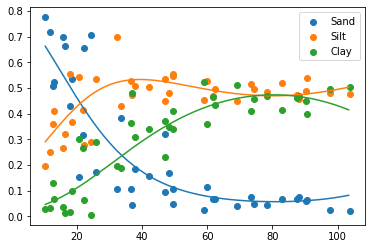

In [198]:
plt.scatter(X_arctic,Y_arctic[:,0],label='Sand')
plt.scatter(X_arctic,Y_arctic[:,1],label='Silt')
plt.scatter(X_arctic,Y_arctic[:,2],label='Clay')
plt.plot(X_new, mu_arctic_2)
plt.legend()
plt.show()

In [130]:
dirichlet_regression.dirichlet_loglikelihood(compute_mu_2(X_arctic_2, beta_arctic_2), np.ones(39), Y_arctic)

2.490675957099221

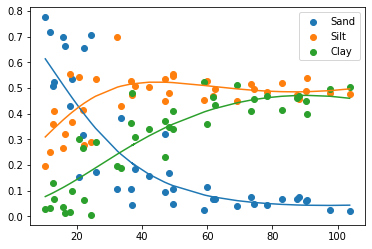

In [135]:
plt.scatter(X_arctic,Y_arctic[:,0],label='Sand')
plt.scatter(X_arctic,Y_arctic[:,1],label='Silt')
plt.scatter(X_arctic,Y_arctic[:,2],label='Clay')
plt.plot(X_arctic, compute_mu_ter(X_arctic, beta_true, intercept_true, beta2_true))
plt.legend()
plt.show()

In [131]:
dirichlet_regression.dirichlet_loglikelihood(compute_mu_ter(X_arctic, beta_true, intercept_true, beta2_true), 
                                             np.ones(39), Y_arctic)

-12.519344575908272

In [132]:
r2_score(Y_arctic, compute_mu_ter(X_arctic, beta_true, intercept_true, beta2_true))

0.6756225377194269

In [133]:
r2_score(Y_arctic, compute_mu_2(X_arctic_2, beta_arctic_2))

0.2227556850971041

## With own gradient descent

In [183]:
def gradientDescent(X, Y, Z, params_0, learning_rate=0.001, nitermax=1000, tolmax=1e-3,epsilon=0):
    K = X.shape[-1]
    J = Y.shape[-1]
    current_param = params_0
    list_likelihoods = []
    list_gradients = []
    list_params = [current_param]
    
    niter=0
    tol=1
    
    current_phi = np.ones(39)

    while (tol > tolmax) & (niter<nitermax):
        #current_phi = np.exp(np.matmul(Z,gamma_var))
        #current_mu = dirichlet_regression.compute_mu(X, current_beta)
        #list_likelihoods.append(dirichlet_regression.dirichlet_loglikelihood(current_mu,current_phi,Y))
        
        grad = fprime_arctic(current_param,X,Y,Z,epsilon=epsilon)
        
        list_gradients.append(grad)
        # we want to maximize the function, so we add the gradient
        old_param = np.copy(current_param)
        current_param = current_param + learning_rate * grad
        #current_beta[:,0] = 0
        list_params.append(current_param)
        
        niter+=1
        tol = np.sum((current_param - old_param)**2)**0.5
        
    return(list_params, list_likelihoods, list_gradients)

In [148]:
beta0 = np.array([[0.1, -0.3, -1.1],[ 0.02, 0.05, 0.06]])
gamma0 = [0,0]
params0 = np.concatenate([beta0.flatten(),gamma0])

In [149]:
list_params, list_likelihoods, list_gradients=gradientDescent(X_arctic_1, Y_arctic, Z_arctic_1, 
                                                              params0, 
                                                              nitermax = 500, learning_rate=1e-6,tolmax=1e-5)

In [150]:
list_params[-2]

array([ 9.49601823e-02, -3.00400801e-01, -1.09455938e+00,  3.06832661e-02,
        4.44712105e-02,  5.48455234e-02,  9.73970407e-04,  4.76804048e-02])

In [151]:
list_params[-1]

array([ 9.49576000e-02, -3.00400954e-01, -1.09455665e+00,  3.06833077e-02,
        4.44712108e-02,  5.48454815e-02,  9.74457290e-04,  4.77042362e-02])

In [152]:
beta_arctic_1 = list_params[-1][:(n_features+1)*n_classes].reshape((n_features+1,n_classes))

In [153]:
mu_arctic_1 = dirichlet_regression.compute_mu(X_new_1, beta_arctic_1)

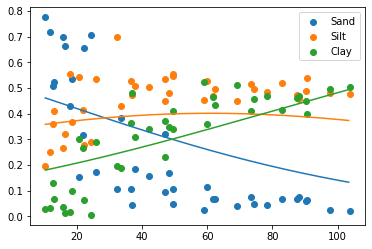

In [154]:
plt.scatter(X_arctic,Y_arctic[:,0],label='Sand')
plt.scatter(X_arctic,Y_arctic[:,1],label='Silt')
plt.scatter(X_arctic,Y_arctic[:,2],label='Clay')
plt.plot(X_new, mu_arctic_1)
plt.legend()
plt.show()

In [22]:
beta0 = np.array([[ 1, 0., -1.], [0, 0., 0.1], [0., 0., 0.]])
gamma0 = [0,0,0]
params0 = np.concatenate([beta0.flatten(),gamma0])

In [23]:
list_params, list_likelihoods, list_gradients=gradientDescent(X_arctic_2, Y_arctic, Z_arctic_2, 
                                                              params0, 
                                                              nitermax = 2000, learning_rate=1e-7,tolmax=1e-5)

NameError: name 'gradientDescent' is not defined

In [200]:
len(list_params)

2001

In [201]:
list_params[-1]

array([ 9.99939708e-01,  5.49380302e-05, -9.99994646e-01, -4.49426746e-04,
        6.63521665e-04,  9.97859051e-02,  1.18080398e-02,  2.91032993e-03,
       -1.47183697e-02,  4.45058391e-07,  1.97110264e-05,  1.18272026e-03])

In [202]:
beta_arctic_2 = list_params[-1][:(n_features+2)*n_classes].reshape((n_features+2,n_classes))

In [203]:
mu_arctic_2 = dirichlet_regression.compute_mu(X_new_2, beta_arctic_2)

### Without phi

In [84]:
def fprime_no_phi(x, X, Y, epsilon=0):
    K = X.shape[-1]
    J = Y.shape[-1]
    beta = x.reshape((K,J))
    #beta[:,0] = 0
    mu = dirichlet_regression.compute_mu(X, beta)
    beta_grad = dirichlet_regression.dirichlet_gradient(mu, X, Y, epsilon=epsilon)
    return(beta_grad.flatten())

In [94]:
beta0 = np.array([[ 1.4, 0., -1.8], [0, 0., 0.], [0., 0., 0.]])

In [95]:
%%time
solution_arctic_no_phi=scipy.optimize.root(fprime_no_phi, beta0,
                                     args=(X_arctic_2, Y_arctic), tol=1e-6, method='hybr')

Wall time: 760 ms


In [96]:
print(solution_arctic_no_phi.message)
solution_arctic_no_phi.x

The solution converged.


array([ 3.76163873e-01, -1.60265202e-01, -8.99054128e-01, -2.57937456e-02,
        3.01802061e-03,  2.08324531e-02,  5.61810061e-04,  3.86174394e-04,
        2.78372595e-04])

In [97]:
beta_arctic_2_no_phi = solution_arctic_no_phi.x.reshape((n_features+2,n_classes))

In [98]:
mu_arctic_2_no_phi = dirichlet_regression.compute_mu(X_new_2, beta_arctic_2_no_phi)

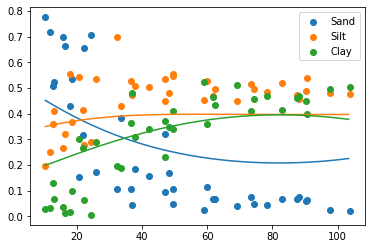

In [99]:
plt.scatter(X_arctic,Y_arctic[:,0],label='Sand')
plt.scatter(X_arctic,Y_arctic[:,1],label='Silt')
plt.scatter(X_arctic,Y_arctic[:,2],label='Clay')
plt.plot(X_new, mu_arctic_2_no_phi)
plt.legend()
plt.show()

In [181]:
r2_score(Y_arctic,dirichlet_regression.compute_mu(X_arctic_2, beta_arctic_2_no_phi))

0.21809447480077349

## What is obtained with DirichletReg on R

In [82]:
beta_true = [[0.02335, 0.05557, 0.0643]]
intercept_true = [[ 0.11662, -0.31060, -1.152]] 

In [83]:
def compute_mu_bis(X, beta, intercept):
    n = np.shape(X)[0]
    J = np.shape(beta)[1]
    Xbeta = np.matmul(X,beta)
    for i in range(n):
        Xbeta[i,:] = Xbeta[i,:]+intercept 
    mu = np.zeros((n,J))
    # compute the softmax
    exp_Xbeta = np.exp(Xbeta)
    sum_exp_Xbeta = np.sum(exp_Xbeta,axis=1)
    for i in range(n):
        mu[i,:] = exp_Xbeta[i,:]/sum_exp_Xbeta[i]
    return mu

In [84]:
min(X_arctic),max(X_arctic)

(array([10.4]), array([103.7]))

In [21]:
X_new = np.arange(10.4,103.7,0.5)
X_new = np.array([[j] for j in X_new])

In [86]:
mu_new = compute_mu_bis(X_new, beta_true, intercept_true)

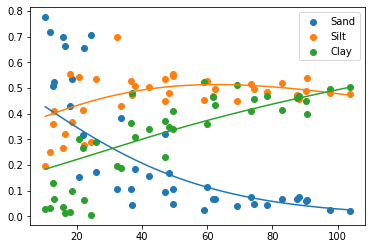

In [87]:
plt.scatter(X_arctic,Y_arctic[:,0],label='Sand')
plt.scatter(X_arctic,Y_arctic[:,1],label='Silt')
plt.scatter(X_arctic,Y_arctic[:,2],label='Clay')
plt.plot(X_new, mu_new)
plt.legend()
plt.show()

In [17]:
intercept_true = [[ 1.4361967, -0.0259705, -1.7931487]] 
beta_true = [[-0.0072382, 0.0717450, 0.1107906]]
beta2_true = [[ 0.0001324, -0.0002679, -0.0004872]] 

In [18]:
def compute_mu_ter(X, beta, intercept, beta2):
    n = np.shape(X)[0]
    J = np.shape(beta)[1]
    Xbeta = np.matmul(X,beta)
    X2beta2 = np.matmul(X**2,beta2)
    for i in range(n):
        Xbeta[i,:] = X2beta2[i,:]+Xbeta[i,:]+intercept 
    mu = np.zeros((n,J))
    # compute the softmax
    exp_Xbeta = np.exp(Xbeta)
    sum_exp_Xbeta = np.sum(exp_Xbeta,axis=1)
    for i in range(n):
        mu[i,:] = exp_Xbeta[i,:]/sum_exp_Xbeta[i]
    return mu

In [94]:
mu_new = compute_mu_ter(X_new, beta_true, intercept_true, beta2_true)

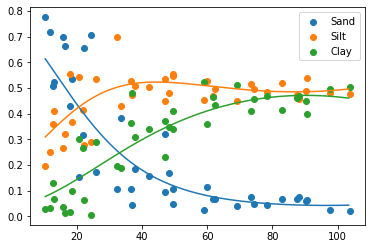

In [95]:
plt.scatter(X_arctic,Y_arctic[:,0],label='Sand')
plt.scatter(X_arctic,Y_arctic[:,1],label='Silt')
plt.scatter(X_arctic,Y_arctic[:,2],label='Clay')
plt.plot(X_new, mu_new)
plt.legend()
plt.show()

In [92]:
r2_score(Y_arctic, compute_mu_ter(X_arctic, beta_true, intercept_true, beta2_true))

0.6756225377194269

In [93]:
np.sum(Y_arctic,axis=0)

array([ 9.438, 17.818, 11.743])

In [94]:
len(Y_arctic)

39

In [95]:
import smote_cd

In [90]:
X_arctic_os, Y_arctic_os = smote_cd.oversampling_multioutput(X_arctic, Y_arctic)

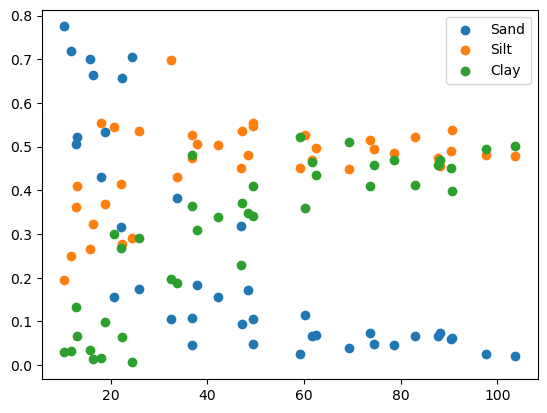

In [93]:
plt.scatter(X_arctic,Y_arctic[:,0],label='Sand')
plt.scatter(X_arctic,Y_arctic[:,1],label='Silt')
plt.scatter(X_arctic,Y_arctic[:,2],label='Clay')
#plt.plot(X_new, mu_new)
plt.legend()
plt.show()

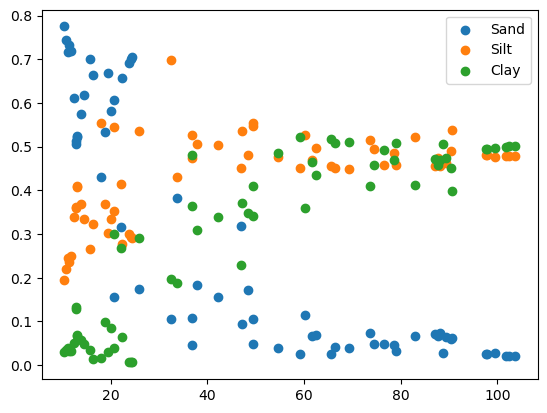

In [92]:
plt.scatter(X_arctic_os,Y_arctic_os[:,0],label='Sand')
plt.scatter(X_arctic_os,Y_arctic_os[:,1],label='Silt')
plt.scatter(X_arctic_os,Y_arctic_os[:,2],label='Clay')
#plt.plot(X_new, mu_new)
plt.legend()
plt.show()

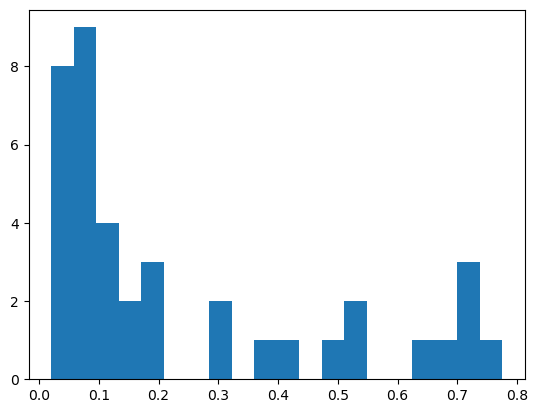

In [101]:
plt.hist(Y_arctic[:,0], bins=20)
plt.show()

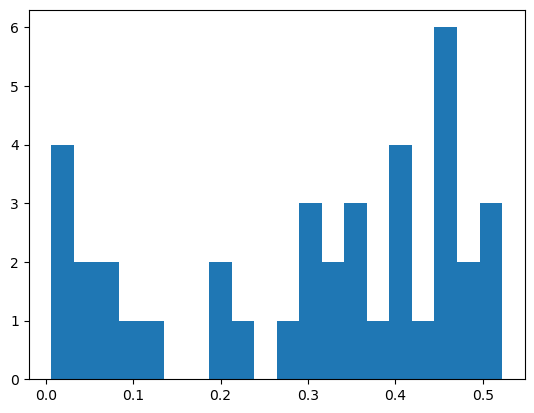

In [100]:
plt.hist(Y_arctic[:,2], bins=20)
plt.show()

In [102]:
np.sum(Y_arctic,axis=0)/np.sum(Y_arctic)

array([0.24200621, 0.45688351, 0.30111028])

In [95]:
np.sum(Y_arctic_os,axis=0)/np.sum(Y_arctic_os)

array([0.28385791, 0.42979667, 0.28634543])

# Comparaison des likelihood

In [46]:
beta_arctic_2

array([[ 5.31504084e-01, -4.90414264e-03, -7.43694690e-01],
       [-7.08068799e-03,  2.17292632e-02,  3.95446102e-02],
       [ 5.27078769e-04,  3.51462021e-04,  2.43649407e-04]])

In [47]:
intercept_true

[[1.4361967, -0.0259705, -1.7931487]]

In [161]:
mu_arctic_2 = dirichlet_regression.compute_mu(X_arctic_2,beta_arctic_2)

In [102]:
dirichlet_regression.dirichlet_loglikelihood(mu_arctic_2, phi_arctic_2, Y_arctic)

49.05283798414962

In [116]:
dirichlet_regression.dirichlet_loglikelihood(compute_mu_ter(X_arctic, beta_true, intercept_true, beta2_true), 
                                             phi_arctic_2, Y_arctic)

54.90714973914159

---

In [79]:
from scipy.special import loggamma

In [88]:
def dirichlet_loglikelihood_no_phi(mu,Y,epsilon=0):
    n = np.shape(Y)[0]
    sum_ll = 0
    for i in range(n):
        term_A = loggamma(np.sum(mu[i]))
        term_B = np.sum(loggamma(mu[i]))
        term_C = np.sum((mu[i]-1)*np.log(Y[i]+epsilon))
        sum_ll += term_A + term_C - term_B
    return sum_ll

In [44]:
r2_score(Y_arctic, compute_mu_ter(X_arctic, beta_true, intercept_true, beta2_true))

0.6756225377194269

In [162]:
r2_score(Y_arctic, dirichlet_regression.compute_mu(X_arctic_2,beta_arctic_2))

0.5012346539814307

In [54]:
np.log(gamma(1))

0.0

In [163]:
dirichlet_loglikelihood_no_phi(compute_mu_ter(X_arctic, beta_true, intercept_true, beta2_true), Y_arctic)

-12.519344575908269

In [164]:
dirichlet_loglikelihood_no_phi(dirichlet_regression.compute_mu(X_arctic_2,beta_arctic_2), Y_arctic)

-10.582358302459484

In [83]:
alpha_1 = np.exp(np.matmul(X_arctic_2,beta_arctic_2))

In [84]:
alpha_2 = np.exp(np.matmul(X_arctic_2,np.array([intercept_true[0], beta_true[0], beta2_true[0]])))

In [89]:
dirichlet_loglikelihood_no_phi(alpha_1, Y_arctic)

-673.3460649616601

In [90]:
dirichlet_loglikelihood_no_phi(alpha_2, Y_arctic)

108.77833131416085

In [108]:
true_params = np.array([[0, -1.7471939375, -4.1558203475],
                       [0, 0.0949597540, 0.1551641068],
                       [0,  -0.0005857499, -0.0009607057]])
true_gamma = 2.9464265445
Z = np.ones(39)
true_phi = np.exp(Z*true_gamma)

In [102]:
true_mu_alt = dirichlet_regression.compute_mu(X_arctic_2,true_params)

In [110]:
dirichlet_regression.dirichlet_loglikelihood(true_mu_alt, true_phi, Y_arctic)

91.28038830278896

In [199]:
gamma_var_arctic_2

array([2.94592283])

In [200]:
phi_arctic_2 = np.exp(Z*gamma_var_arctic_2)
mu_arctic_2 = dirichlet_regression.compute_mu(X_arctic_2,beta_arctic_2)
dirichlet_regression.dirichlet_loglikelihood(mu_arctic_2, true_phi, Y_arctic)

91.28038768684509

Pourquoi ça ne marchait pas ?

- Dimension de gamma et Z était incorrecte (il faut juste Z de dimension 39,1 et gamma un réel) 
- Arguments de départs : il faut qu'ils soient assez proches de ceux optims, d'où l'échauffement avec BFGS

TODO:

- Clean le code
- Les fonctions de calcul de LL et gradient (normalement c'est bon)